In [49]:
import importlib

In [53]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile

from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table

from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda


In [63]:
import plots_and_stats

In [64]:
importlib.reload(plots_and_stats)
from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table

In [45]:
from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%reload_ext autoreload

from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [3]:
cols = [
    
    'dr_naive_mean', 'dr_naive_ci_low', 'dr_naive_ci_high', 'dr_naive_se',
    'dr_boot_mean', 'dr_boot_std', 'dr_boot_ci_low', 'dr_boot_ci_high',
    'ipw_boot_mean', 'ipw_boot_std', 'ipw_boot_ci_low', 'ipw_boot_ci_high',

    'cv_rmse_uniform', 'cv_signed_rmse_uniform', 'cv_bias_uniform',
    'cv_bias_lb_signed_uniform', 'cv_rmse_exp', 'cv_signed_rmse_exp',
    'cv_bias_exp', 'cv_bias_lb_signed_exp', 'loss_uniform', 'loss_exp',
    'score_naive_minus_cv_uniform', 'score_naive_minus_cv_exp'
    ]

In [4]:
'Spearman Kendall-Tau'.split()

['Spearman', 'Kendall-Tau']

In [5]:
cols = ['dr_naive_mean', 'dr_naive_ci_low',
         'dr_boot_mean', 'dr_boot_ci_low',
         'dr_uni_mean', 'dr_uni_ci_low',
         'ipw_boot_mean', 'ipw_boot_ci_low',
         'ipw_uni_mean', 'ipw_uni_ci_low']

In [6]:
# for num in [10000, 20000, 30000, 40000, 50000, 12345]:
#     df = pd.read_csv(f"trial_dfs/study_df_155_{num}.csv")

#     rank_tbl = plot_calibration_and_rank_table(
#         df,
#         cols=cols,
#         reward_col="user_attrs_actual_reward"
#     )

#     print(f"Num samples: {num}")
#     display(rank_tbl)

In [7]:
# df = pd.read_csv("trial_dfs/study_df_27_40000.csv")

# rank_tbl = plot_calibration_and_rank_table(
#     df,
#     cols=cols,
#     reward_col="user_attrs_actual_reward"
# ) 

# rank_tbl

In [8]:
n_actions = 3000
n_users = 3000
emb_dim = 12

dataset_params = dict(
                    n_actions=n_actions,
                    n_users=n_users,
                    emb_dim=emb_dim,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07297099303656977
Optimal greedy CTR: 0.09999902635550757
Second Best greedy CTR: 0.09179790935178184
Optimal Stochastic CTR: 0.09986644209494033
second Best Stochastic CTR: 0.08475281474508535
Our Initial CTR: 0.08478425519214075


In [9]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 30
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [250000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.0025,  # Learning rate
    "num_epochs": 8,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.98  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [10]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [250000]
Simulation time for 200000 samples: 2.840071201324463 seconds
[Regression] Baseline regression model fit time: 0.61s
Num samples is 100000
{'gini': np.float64(0.4165249849589453), 'ess': np.float64(52999.94492091207), 'max_wi': np.float64(30.64533944781268), 'min_wi': np.float64(0.008962395784430583)}
Eval time: 36.32186222076416 seconds
Evaluation total results time: 69.85 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 10:34:23,292] A new study created in memory with name: no-name-6409d933-321f-4234-8b10-f512921276c5


Simulation time for 350000 samples: 4.785261869430542 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.0901121]


Best trial: 0. Best value: 0.0877879:   3%|▎         | 1/30 [00:39<19:14, 39.81s/it]

[I 2026-01-04 10:35:03,101] Trial 0 finished with value: 0.08778785059371126 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 1
actual reward: [0.08681637]


Best trial: 0. Best value: 0.0877879:   7%|▋         | 2/30 [00:52<11:03, 23.69s/it]

[I 2026-01-04 10:35:15,507] Trial 1 finished with value: 0.08625737771258028 and parameters: {'lr': 0.0020557736235433804, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9683421448803977}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 2
actual reward: [0.07246351]


Best trial: 0. Best value: 0.0877879:  10%|█         | 3/30 [01:04<08:18, 18.46s/it]

[I 2026-01-04 10:35:27,737] Trial 2 finished with value: 0.08461695425058008 and parameters: {'lr': 0.07917759773825093, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9526760875470821}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 3
actual reward: [0.08029869]


Best trial: 0. Best value: 0.0877879:  13%|█▎        | 4/30 [01:26<08:33, 19.73s/it]

[I 2026-01-04 10:35:49,426] Trial 3 finished with value: 0.08428654433012081 and parameters: {'lr': 0.050940570593933136, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9561695413243578}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 4
actual reward: [0.08030789]


Best trial: 0. Best value: 0.0877879:  17%|█▋        | 5/30 [01:38<07:08, 17.14s/it]

[I 2026-01-04 10:36:01,982] Trial 4 finished with value: 0.08353455681297012 and parameters: {'lr': 0.0006056788947731745, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9104017469949256}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 5
actual reward: [0.08929759]


Best trial: 0. Best value: 0.0877879:  20%|██        | 6/30 [02:04<08:01, 20.06s/it]

[I 2026-01-04 10:36:27,703] Trial 5 finished with value: 0.08709087169789045 and parameters: {'lr': 0.003268268100469647, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8149218501976391}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 6
actual reward: [0.08336354]


Best trial: 0. Best value: 0.0877879:  23%|██▎       | 7/30 [02:18<06:54, 18.03s/it]

[I 2026-01-04 10:36:41,540] Trial 6 finished with value: 0.08407511037292649 and parameters: {'lr': 0.00018268074054730746, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9871880418061942}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 7
actual reward: [0.07584524]


Best trial: 0. Best value: 0.0877879:  27%|██▋       | 8/30 [02:29<05:49, 15.90s/it]

[I 2026-01-04 10:36:52,896] Trial 7 finished with value: 0.0837090246277165 and parameters: {'lr': 0.03285561510956071, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8839846115557098}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 8
actual reward: [0.07570912]


Best trial: 0. Best value: 0.0877879:  30%|███       | 9/30 [02:35<04:27, 12.73s/it]

[I 2026-01-04 10:36:58,644] Trial 8 finished with value: 0.08379985358348267 and parameters: {'lr': 0.04262746269390715, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8004916028535217}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 9
actual reward: [0.08500816]


Best trial: 0. Best value: 0.0877879:  33%|███▎      | 10/30 [02:54<04:55, 14.77s/it]

[I 2026-01-04 10:37:17,989] Trial 9 finished with value: 0.08715248726193195 and parameters: {'lr': 0.018150409691360284, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.840991341518447}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 10
actual reward: [0.09021604]


Best trial: 0. Best value: 0.0877879:  37%|███▋      | 11/30 [03:33<06:59, 22.07s/it]

[I 2026-01-04 10:37:56,595] Trial 10 finished with value: 0.08693565847117089 and parameters: {'lr': 0.006920942662651453, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9164599903552333}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 11
actual reward: [0.08316416]


Best trial: 0. Best value: 0.0877879:  40%|████      | 12/30 [03:49<06:03, 20.22s/it]

[I 2026-01-04 10:38:12,598] Trial 11 finished with value: 0.086867414797808 and parameters: {'lr': 0.00971639603739993, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8529553528119054}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 12
actual reward: [0.08696761]


Best trial: 0. Best value: 0.0877879:  43%|████▎     | 13/30 [04:08<05:39, 19.99s/it]

[I 2026-01-04 10:38:32,046] Trial 12 finished with value: 0.0871333027830138 and parameters: {'lr': 0.010917861364514812, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8522536703619327}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 13
actual reward: [0.07726507]


Best trial: 0. Best value: 0.0877879:  47%|████▋     | 14/30 [04:25<05:04, 19.02s/it]

[I 2026-01-04 10:38:48,832] Trial 13 finished with value: 0.08320757369151821 and parameters: {'lr': 0.0011834593508500211, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8695182560484267}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 14
actual reward: [0.08390257]


Best trial: 0. Best value: 0.0877879:  50%|█████     | 15/30 [05:00<05:57, 23.80s/it]

[I 2026-01-04 10:39:23,724] Trial 14 finished with value: 0.0844186442231525 and parameters: {'lr': 0.019764930704850425, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9258509179785416}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 15
actual reward: [0.07930557]


Best trial: 0. Best value: 0.0877879:  53%|█████▎    | 16/30 [05:19<05:14, 22.49s/it]

[I 2026-01-04 10:39:43,168] Trial 15 finished with value: 0.08339198158045127 and parameters: {'lr': 0.0003842101434991953, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9970288295491604}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 16
actual reward: [0.08975811]


Best trial: 0. Best value: 0.0877879:  57%|█████▋    | 17/30 [06:03<06:13, 28.73s/it]

[I 2026-01-04 10:40:26,411] Trial 16 finished with value: 0.0876166395558569 and parameters: {'lr': 0.00437311986035077, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8307705789206692}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 17
actual reward: [0.08986095]


Best trial: 0. Best value: 0.0877879:  60%|██████    | 18/30 [06:37<06:05, 30.45s/it]

[I 2026-01-04 10:41:00,852] Trial 17 finished with value: 0.08699307408497693 and parameters: {'lr': 0.004202581645547305, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9351740174817158}. Best is trial 0 with value: 0.08778785059371126.

[Regression] Optuna Trial 18
actual reward: [0.08803097]


Best trial: 18. Best value: 0.0879:  63%|██████▎   | 19/30 [07:12<05:49, 31.77s/it]  

[I 2026-01-04 10:41:35,715] Trial 18 finished with value: 0.08790003259317741 and parameters: {'lr': 0.0012155181606718734, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8927246189465678}. Best is trial 18 with value: 0.08790003259317741.

[Regression] Optuna Trial 19
actual reward: [0.08723703]


Best trial: 18. Best value: 0.0879:  67%|██████▋   | 20/30 [07:42<05:11, 31.14s/it]

[I 2026-01-04 10:42:05,369] Trial 19 finished with value: 0.08772209397658466 and parameters: {'lr': 0.0009348489038679546, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8916014632055429}. Best is trial 18 with value: 0.08790003259317741.

[Regression] Optuna Trial 20
actual reward: [0.08405435]


Best trial: 18. Best value: 0.0879:  70%|███████   | 21/30 [08:16<04:50, 32.24s/it]

[I 2026-01-04 10:42:40,178] Trial 20 finished with value: 0.08476409639233014 and parameters: {'lr': 0.00016965269296828316, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9382558530075213}. Best is trial 18 with value: 0.08790003259317741.

[Regression] Optuna Trial 21
actual reward: [0.08790064]


Best trial: 21. Best value: 0.0880283:  73%|███████▎  | 22/30 [08:46<04:12, 31.57s/it]

[I 2026-01-04 10:43:10,197] Trial 21 finished with value: 0.08802829233733368 and parameters: {'lr': 0.0011943690637723856, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8893608402979571}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 22
actual reward: [0.08837802]


Best trial: 21. Best value: 0.0880283:  77%|███████▋  | 23/30 [09:17<03:38, 31.18s/it]

[I 2026-01-04 10:43:40,445] Trial 22 finished with value: 0.08782454375944221 and parameters: {'lr': 0.0018445957433498492, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8740486465261407}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 23
actual reward: [0.08781455]


Best trial: 21. Best value: 0.0880283:  80%|████████  | 24/30 [09:46<03:04, 30.69s/it]

[I 2026-01-04 10:44:09,990] Trial 23 finished with value: 0.08790224359198849 and parameters: {'lr': 0.0013999173660513874, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8736281585190075}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 24
actual reward: [0.08573682]


Best trial: 21. Best value: 0.0880283:  83%|████████▎ | 25/30 [10:16<02:32, 30.56s/it]

[I 2026-01-04 10:44:40,256] Trial 24 finished with value: 0.08663294033436049 and parameters: {'lr': 0.00041051933227521307, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.903407365231218}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 25
actual reward: [0.08702317]


Best trial: 21. Best value: 0.0880283:  87%|████████▋ | 26/30 [10:38<01:50, 27.74s/it]

[I 2026-01-04 10:45:01,432] Trial 25 finished with value: 0.08754895473345524 and parameters: {'lr': 0.0012330227634005518, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8659210731882545}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 26
actual reward: [0.08591875]


Best trial: 21. Best value: 0.0880283:  90%|█████████ | 27/30 [10:59<01:17, 25.77s/it]

[I 2026-01-04 10:45:22,581] Trial 26 finished with value: 0.08705508050973818 and parameters: {'lr': 0.0006635895227795573, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8924101671789026}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 27
actual reward: [0.08602385]


Best trial: 21. Best value: 0.0880283:  93%|█████████▎| 28/30 [11:33<00:56, 28.26s/it]

[I 2026-01-04 10:45:56,651] Trial 27 finished with value: 0.08695602797007658 and parameters: {'lr': 0.0004642173083670263, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8824306034335991}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 28
actual reward: [0.08305791]


Best trial: 21. Best value: 0.0880283:  97%|█████████▋| 29/30 [11:47<00:24, 24.09s/it]

[I 2026-01-04 10:46:11,026] Trial 28 finished with value: 0.0840461769709442 and parameters: {'lr': 0.0002425470191303452, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9043448490609979}. Best is trial 21 with value: 0.08802829233733368.

[Regression] Optuna Trial 29
actual reward: [0.08881615]


Best trial: 21. Best value: 0.0880283: 100%|██████████| 30/30 [12:30<00:00, 25.02s/it]


[I 2026-01-04 10:46:53,961] Trial 29 finished with value: 0.08778851528604145 and parameters: {'lr': 0.0017977065320619477, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.858955794532222}. Best is trial 21 with value: 0.08802829233733368.
Num samples is 100000
{'gini': np.float64(0.97024727545836), 'ess': np.float64(1087.4747981530147), 'max_wi': np.float64(847.528428818766), 'min_wi': np.float64(7.599310270009607e-07)}
Eval time: 36.23097825050354 seconds
Evaluation total results time: 69.45 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08478426,0.08635000,0.08762562,0.08762562,0.08634931,0.08634931,0.84192601,0.00000000,1.14920499,0.00000000
250000,0.08517750,0.08634456,0.08460137,0.08460137,0.08637132,0.08649226,0.92797581,0.25886711,1.21784868,0.11627466


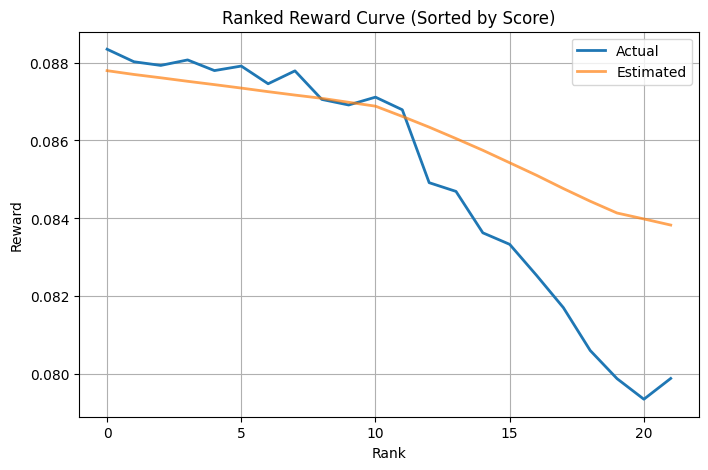

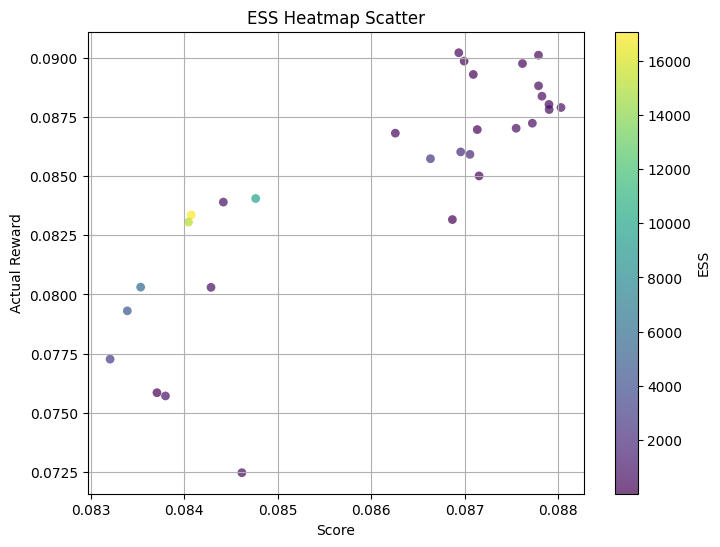

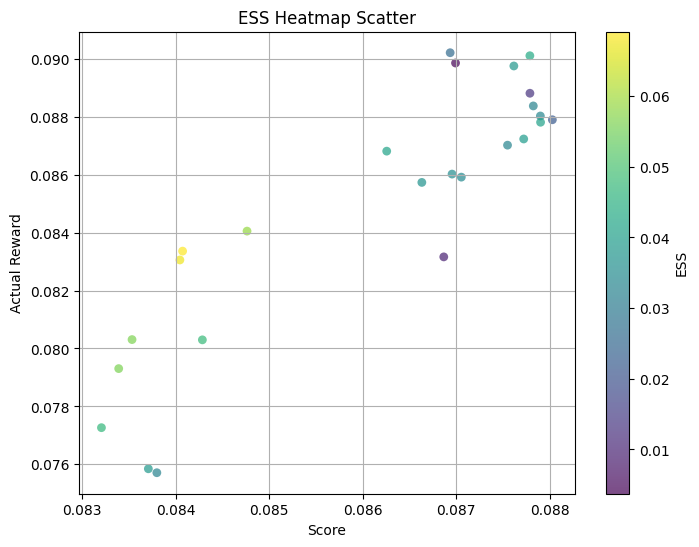

Correlation Metrics: {'pearson_score_actual': np.float64(0.8343759037157628), 'spearman_score_actual': np.float64(0.8020022246941045), 'spearman_est_actual': np.float64(0.8051167964404894)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9952175116499674), 'ndcg_est_actual': np.float64(0.9952444771418245)}
Error Metrics: {'mean_error': np.float64(-0.001763128662723827), 'mae': np.float64(0.0026088706602710385), 'rmse': np.float64(0.0038081888524449077), 'std_error': np.float64(0.0033754525110816407), 'max_error': np.float64(0.0030131822884151283), 'min_error': np.float64(-0.012235560668875364)}


In [65]:
# study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [12]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = emb_dim,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07299616499379533
Optimal greedy CTR: 0.09999912765877851
Second Best greedy CTR: 0.09924234208905701
Optimal Stochastic CTR: 0.09986822971033672
second Best Stochastic CTR: 0.08585992378345159
Our Initial CTR: 0.08589106637164244


In [13]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{100000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 200000 samples: 2.9695651531219482 seconds
[Regression] Baseline regression model fit time: 0.33s
Num samples is 100000
{'gini': np.float64(0.4125446952435058), 'ess': np.float64(54194.00130745827), 'max_wi': np.float64(25.615993016803504), 'min_wi': np.float64(0.009995965102838693)}
Eval time: 36.08143162727356 seconds
Evaluation total results time: 67.54 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 10:49:34,305] A new study created in memory with name: no-name-153cd264-7ac7-4851-a594-fedc1493abd0


Simulation time for 350000 samples: 4.3926684856414795 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09136863]


Best trial: 0. Best value: 0.0883776:   3%|▎         | 1/30 [00:35<17:06, 35.41s/it]

[I 2026-01-04 10:50:09,716] Trial 0 finished with value: 0.08837757720602346 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 1
actual reward: [0.08639099]


Best trial: 0. Best value: 0.0883776:   7%|▋         | 2/30 [00:40<08:18, 17.82s/it]

[I 2026-01-04 10:50:15,219] Trial 1 finished with value: 0.08357879821692782 and parameters: {'lr': 0.0018270275302660957, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9872789723014228}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 2
actual reward: [0.08625461]


Best trial: 0. Best value: 0.0883776:  10%|█         | 3/30 [01:16<11:39, 25.90s/it]

[I 2026-01-04 10:50:50,726] Trial 2 finished with value: 0.08440448588400884 and parameters: {'lr': 0.00010943160327463597, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8376908121795166}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 3
actual reward: [0.0893783]


Best trial: 0. Best value: 0.0883776:  13%|█▎        | 4/30 [01:32<09:31, 21.98s/it]

[I 2026-01-04 10:51:06,712] Trial 3 finished with value: 0.08743136223647865 and parameters: {'lr': 0.005895214868394568, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9512929465141857}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 4
actual reward: [0.08654805]


Best trial: 0. Best value: 0.0883776:  17%|█▋        | 5/30 [02:07<11:11, 26.85s/it]

[I 2026-01-04 10:51:42,195] Trial 4 finished with value: 0.08314451067365496 and parameters: {'lr': 0.0003849456433579582, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9671840350236083}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 5
actual reward: [0.07858424]


Best trial: 0. Best value: 0.0883776:  20%|██        | 6/30 [02:20<08:48, 22.01s/it]

[I 2026-01-04 10:51:54,820] Trial 5 finished with value: 0.08256508758104107 and parameters: {'lr': 0.08563241278753662, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8561647977835083}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 6
actual reward: [0.08616581]


Best trial: 0. Best value: 0.0883776:  23%|██▎       | 7/30 [02:32<07:08, 18.63s/it]

[I 2026-01-04 10:52:06,495] Trial 6 finished with value: 0.0823232575498155 and parameters: {'lr': 0.0013631726320981147, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9561379775639296}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 7
actual reward: [0.08636231]


Best trial: 0. Best value: 0.0883776:  27%|██▋       | 8/30 [02:43<05:57, 16.24s/it]

[I 2026-01-04 10:52:17,611] Trial 7 finished with value: 0.08412021743982444 and parameters: {'lr': 0.00030527920203576636, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.986873056747186}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 8
actual reward: [0.08633315]


Best trial: 0. Best value: 0.0883776:  30%|███       | 9/30 [03:06<06:25, 18.33s/it]

[I 2026-01-04 10:52:40,547] Trial 8 finished with value: 0.08420873138659274 and parameters: {'lr': 0.0001340328020976567, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.98174672698976}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 9
actual reward: [0.0811924]


Best trial: 0. Best value: 0.0883776:  33%|███▎      | 10/30 [03:12<04:51, 14.56s/it]

[I 2026-01-04 10:52:46,662] Trial 9 finished with value: 0.08204329198425485 and parameters: {'lr': 0.04288067243572375, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9765969757765852}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 10
actual reward: [0.09095586]


Best trial: 0. Best value: 0.0883776:  37%|███▋      | 11/30 [03:39<05:50, 18.43s/it]

[I 2026-01-04 10:53:13,870] Trial 10 finished with value: 0.08634757273138553 and parameters: {'lr': 0.010559875797439956, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9103440034035017}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 11
actual reward: [0.08800361]


Best trial: 0. Best value: 0.0883776:  40%|████      | 12/30 [03:55<05:19, 17.73s/it]

[I 2026-01-04 10:53:29,983] Trial 11 finished with value: 0.08830415601777684 and parameters: {'lr': 0.01105823136182145, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9266968607859147}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 12
actual reward: [0.08862888]


Best trial: 0. Best value: 0.0883776:  43%|████▎     | 13/30 [04:39<07:15, 25.59s/it]

[I 2026-01-04 10:54:13,670] Trial 12 finished with value: 0.08284148154902916 and parameters: {'lr': 0.017594359766939707, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9166103390600177}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 13
actual reward: [0.0890533]


Best trial: 0. Best value: 0.0883776:  47%|████▋     | 14/30 [04:53<05:55, 22.23s/it]

[I 2026-01-04 10:54:28,146] Trial 13 finished with value: 0.08174341758832183 and parameters: {'lr': 0.0036046572640227865, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8798197985683365}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 14
actual reward: [0.0860008]


Best trial: 0. Best value: 0.0883776:  50%|█████     | 15/30 [05:11<05:11, 20.79s/it]

[I 2026-01-04 10:54:45,605] Trial 14 finished with value: 0.0815836555778339 and parameters: {'lr': 0.0009607171357521699, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9406487642232867}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 15
actual reward: [0.0893818]


Best trial: 0. Best value: 0.0883776:  53%|█████▎    | 16/30 [05:42<05:36, 24.05s/it]

[I 2026-01-04 10:55:17,223] Trial 15 finished with value: 0.08305203692981895 and parameters: {'lr': 0.01805456637676037, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8084442511449323}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 16
actual reward: [0.09120012]


Best trial: 16. Best value: 0.0895908:  57%|█████▋    | 17/30 [06:07<05:16, 24.34s/it]

[I 2026-01-04 10:55:42,246] Trial 16 finished with value: 0.08959084748258132 and parameters: {'lr': 0.005418309003953338, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9232712471215323}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 17
actual reward: [0.0906828]


Best trial: 16. Best value: 0.0895908:  60%|██████    | 18/30 [06:35<05:03, 25.26s/it]

[I 2026-01-04 10:56:09,622] Trial 17 finished with value: 0.08725989596289674 and parameters: {'lr': 0.004205417090232096, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8892583136914682}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 18
actual reward: [0.08623775]


Best trial: 16. Best value: 0.0895908:  63%|██████▎   | 19/30 [07:00<04:36, 25.14s/it]

[I 2026-01-04 10:56:34,492] Trial 18 finished with value: 0.08251525166941875 and parameters: {'lr': 0.0005349183217606818, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9343233839299585}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 19
actual reward: [0.08966968]


Best trial: 16. Best value: 0.0895908:  67%|██████▋   | 20/30 [07:17<03:48, 22.87s/it]

[I 2026-01-04 10:56:52,068] Trial 19 finished with value: 0.0853683055360097 and parameters: {'lr': 0.0021201430991910314, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9996100319825257}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 20
actual reward: [0.08631988]


Best trial: 16. Best value: 0.0895908:  70%|███████   | 21/30 [07:24<02:43, 18.11s/it]

[I 2026-01-04 10:56:59,088] Trial 20 finished with value: 0.08422663519987972 and parameters: {'lr': 0.0007664507932886701, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8996143078628374}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 21
actual reward: [0.0915914]


Best trial: 16. Best value: 0.0895908:  73%|███████▎  | 22/30 [08:04<03:17, 24.64s/it]

[I 2026-01-04 10:57:38,942] Trial 21 finished with value: 0.08697469704756232 and parameters: {'lr': 0.010387626959386886, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9254677276852272}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 22
actual reward: [0.09045782]


Best trial: 16. Best value: 0.0895908:  77%|███████▋  | 23/30 [08:24<02:42, 23.24s/it]

[I 2026-01-04 10:57:58,940] Trial 22 finished with value: 0.08872998842537996 and parameters: {'lr': 0.01005681888209635, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8672945789190507}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 23
actual reward: [0.08989558]


Best trial: 16. Best value: 0.0895908:  80%|████████  | 24/30 [08:44<02:13, 22.30s/it]

[I 2026-01-04 10:58:19,042] Trial 23 finished with value: 0.08859399008375686 and parameters: {'lr': 0.006125812726200541, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8643960162901452}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 24
actual reward: [0.08881949]


Best trial: 16. Best value: 0.0895908:  83%|████████▎ | 25/30 [09:04<01:48, 21.64s/it]

[I 2026-01-04 10:58:39,126] Trial 24 finished with value: 0.08551717798045122 and parameters: {'lr': 0.0263741373593153, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.865468672198968}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 25
actual reward: [0.08954904]


Best trial: 25. Best value: 0.0902227:  87%|████████▋ | 26/30 [09:22<01:21, 20.43s/it]

[I 2026-01-04 10:58:56,757] Trial 25 finished with value: 0.09022270634571133 and parameters: {'lr': 0.007302056354651622, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8343990421424431}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 26
actual reward: [0.08329417]


Best trial: 25. Best value: 0.0902227:  90%|█████████ | 27/30 [09:35<00:54, 18.11s/it]

[I 2026-01-04 10:59:09,448] Trial 26 finished with value: 0.08355652376196471 and parameters: {'lr': 0.04135725631756566, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8257916470373178}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 27
actual reward: [0.08990664]


Best trial: 25. Best value: 0.0902227:  93%|█████████▎| 28/30 [09:52<00:36, 18.00s/it]

[I 2026-01-04 10:59:27,197] Trial 27 finished with value: 0.08995675334541593 and parameters: {'lr': 0.00762836994687486, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8445057466726935}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 28
actual reward: [0.08514378]


Best trial: 25. Best value: 0.0902227:  97%|█████████▋| 29/30 [09:58<00:14, 14.16s/it]

[I 2026-01-04 10:59:32,401] Trial 28 finished with value: 0.08215014556518051 and parameters: {'lr': 0.004542918595096549, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.835161113954931}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 29
actual reward: [0.08781328]


Best trial: 25. Best value: 0.0902227: 100%|██████████| 30/30 [10:10<00:00, 20.35s/it]


[I 2026-01-04 10:59:44,846] Trial 29 finished with value: 0.0835514630617558 and parameters: {'lr': 0.002807661265443379, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8181137669409801}. Best is trial 25 with value: 0.09022270634571133.
Num samples is 100000
{'gini': np.float64(0.9948244005497492), 'ess': np.float64(108.0446136577651), 'max_wi': np.float64(4454.032016111014), 'min_wi': np.float64(2.0429332565944305e-11)}
Eval time: 33.85882830619812 seconds
Evaluation total results time: 64.76 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08589107,0.08729000,0.08847519,0.08847519,0.08727182,0.08727182,0.76670009,0.00000000,0.83964109,0.00000000
250000,0.08914573,0.06047118,0.08530101,0.08530101,0.05926623,0.05972741,0.93544951,0.41971851,1.07626387,0.43378664


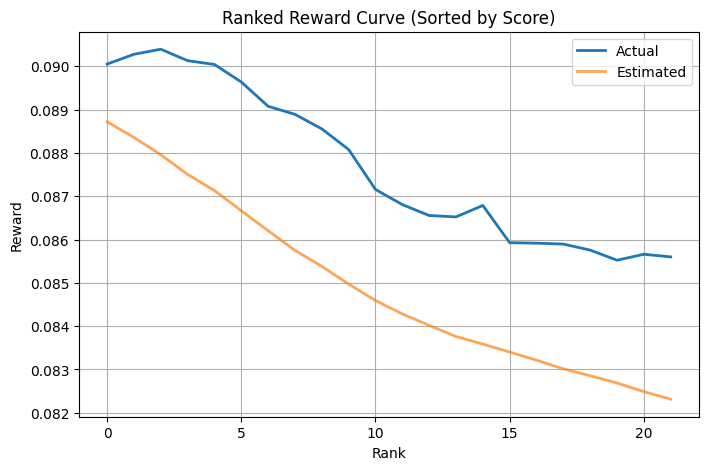

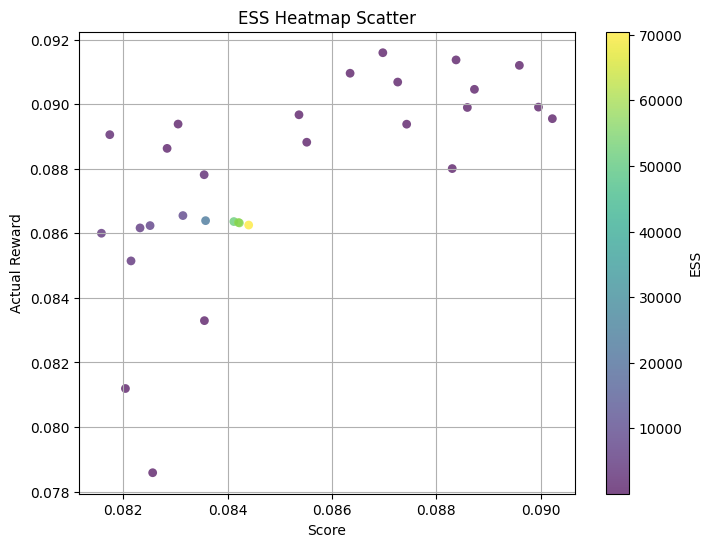

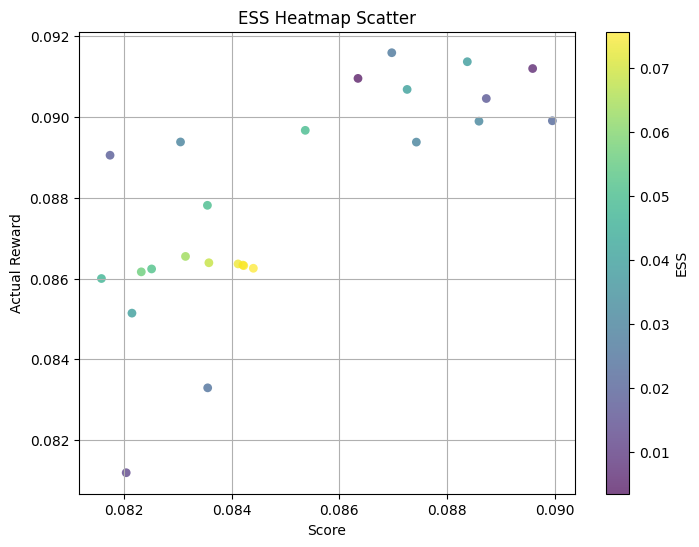

Correlation Metrics: {'pearson_score_actual': np.float64(0.664989032135445), 'spearman_score_actual': np.float64(0.7423804226918799), 'spearman_est_actual': np.float64(0.7486095661846496)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9965517717819093), 'ndcg_est_actual': np.float64(0.9966220921854736)}
Error Metrics: {'mean_error': np.float64(0.00217137515861751), 'mae': np.float64(0.0026405987674196474), 'rmse': np.float64(0.003177371856059052), 'std_error': np.float64(0.0023196598526971416), 'max_error': np.float64(0.007041576379337139), 'min_error': np.float64(-0.004033282742075983)}


In [66]:
compute_statistics_and_plots(study_df5)

In [15]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = 12,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07309055792320392
Optimal greedy CTR: 0.09999897086664764
Second Best greedy CTR: 0.09970300652604132
Optimal Stochastic CTR: 0.09986439645169445
second Best Stochastic CTR: 0.0859222902219525
Our Initial CTR: 0.08595116402443975


In [16]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 200000 samples: 2.5389957427978516 seconds
[Regression] Baseline regression model fit time: 0.21s
Num samples is 100000
{'gini': np.float64(0.41103650434369166), 'ess': np.float64(52716.14511374075), 'max_wi': np.float64(35.67599317713186), 'min_wi': np.float64(0.008284436378410663)}
Eval time: 34.09753441810608 seconds
Evaluation total results time: 64.84 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:02:14,619] A new study created in memory with name: no-name-ae574382-3ca2-4905-b5e8-f21e60af881b


Simulation time for 350000 samples: 4.395092964172363 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09363027]


Best trial: 0. Best value: 0.0855886:   3%|▎         | 1/30 [00:35<17:13, 35.64s/it]

[I 2026-01-04 11:02:50,254] Trial 0 finished with value: 0.08558857686735306 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 1
actual reward: [0.08292874]


Best trial: 0. Best value: 0.0855886:   7%|▋         | 2/30 [00:42<08:47, 18.82s/it]

[I 2026-01-04 11:02:57,311] Trial 1 finished with value: 0.08296120857023544 and parameters: {'lr': 0.09013423754425866, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.894036279084838}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 2
actual reward: [0.09245167]


Best trial: 0. Best value: 0.0855886:  10%|█         | 3/30 [00:55<07:13, 16.04s/it]

[I 2026-01-04 11:03:10,045] Trial 2 finished with value: 0.08298435129520502 and parameters: {'lr': 0.036772762472573384, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.817585348913679}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 3
actual reward: [0.08615229]


Best trial: 0. Best value: 0.0855886:  13%|█▎        | 4/30 [01:08<06:26, 14.86s/it]

[I 2026-01-04 11:03:23,080] Trial 3 finished with value: 0.08477350580971842 and parameters: {'lr': 0.0001157546147455195, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9531802239195943}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 4
actual reward: [0.08620572]


Best trial: 0. Best value: 0.0855886:  17%|█▋        | 5/30 [01:21<05:51, 14.05s/it]

[I 2026-01-04 11:03:35,707] Trial 4 finished with value: 0.08310152580726726 and parameters: {'lr': 0.04717087061134012, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8610878865117106}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 5
actual reward: [0.08648856]


Best trial: 0. Best value: 0.0855886:  20%|██        | 6/30 [01:36<05:44, 14.36s/it]

[I 2026-01-04 11:03:50,669] Trial 5 finished with value: 0.08466149791815675 and parameters: {'lr': 0.00020365735395434085, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8668424618080992}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 6
actual reward: [0.08618422]


Best trial: 0. Best value: 0.0855886:  23%|██▎       | 7/30 [01:43<04:39, 12.16s/it]

[I 2026-01-04 11:03:58,291] Trial 6 finished with value: 0.08476044391963995 and parameters: {'lr': 0.00019624399601446036, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8685853564367996}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 7
actual reward: [0.09309663]


Best trial: 0. Best value: 0.0855886:  27%|██▋       | 8/30 [02:08<05:56, 16.23s/it]

[I 2026-01-04 11:04:23,224] Trial 7 finished with value: 0.08450389936091708 and parameters: {'lr': 0.01413288281217453, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8418607020016358}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 8
actual reward: [0.09303694]


Best trial: 0. Best value: 0.0855886:  30%|███       | 9/30 [02:52<08:42, 24.89s/it]

[I 2026-01-04 11:05:07,177] Trial 8 finished with value: 0.08523817663835896 and parameters: {'lr': 0.002946704967757138, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8119913878455819}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 9
actual reward: [0.0862157]


Best trial: 0. Best value: 0.0855886:  33%|███▎      | 10/30 [03:03<06:53, 20.65s/it]

[I 2026-01-04 11:05:18,337] Trial 9 finished with value: 0.08475171734574413 and parameters: {'lr': 0.00011871007911626979, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9902732926773604}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 10
actual reward: [0.08734051]


Best trial: 0. Best value: 0.0855886:  37%|███▋      | 11/30 [03:10<05:12, 16.43s/it]

[I 2026-01-04 11:05:25,190] Trial 10 finished with value: 0.0843333174444114 and parameters: {'lr': 0.0014857391132526497, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9452182084158526}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 11
actual reward: [0.09237573]


Best trial: 0. Best value: 0.0855886:  40%|████      | 12/30 [03:54<07:24, 24.72s/it]

[I 2026-01-04 11:06:08,868] Trial 11 finished with value: 0.08448144472781174 and parameters: {'lr': 0.0023521553251888757, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8012713448372839}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 12
actual reward: [0.09448091]


Best trial: 12. Best value: 0.0858063:  43%|████▎     | 13/30 [04:33<08:16, 29.20s/it]

[I 2026-01-04 11:06:48,367] Trial 12 finished with value: 0.08580633494649392 and parameters: {'lr': 0.006755189080256751, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9242077659033117}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 13
actual reward: [0.09383453]


Best trial: 12. Best value: 0.0858063:  47%|████▋     | 14/30 [05:09<08:17, 31.12s/it]

[I 2026-01-04 11:07:23,930] Trial 13 finished with value: 0.08488991734291858 and parameters: {'lr': 0.008637496207791369, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9305521976489914}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 14
actual reward: [0.09016351]


Best trial: 12. Best value: 0.0858063:  50%|█████     | 15/30 [05:44<08:05, 32.34s/it]

[I 2026-01-04 11:07:59,112] Trial 14 finished with value: 0.08387621799215457 and parameters: {'lr': 0.0007521087605148642, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9987466789901209}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 15
actual reward: [0.0939382]


Best trial: 12. Best value: 0.0858063:  53%|█████▎    | 16/30 [06:24<08:03, 34.51s/it]

[I 2026-01-04 11:08:38,658] Trial 15 finished with value: 0.08497407592609243 and parameters: {'lr': 0.0069540138266495684, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9693744889057743}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 16
actual reward: [0.09116119]


Best trial: 12. Best value: 0.0858063:  57%|█████▋    | 17/30 [06:59<07:30, 34.68s/it]

[I 2026-01-04 11:09:13,738] Trial 16 finished with value: 0.08424933699734605 and parameters: {'lr': 0.0012616463102917677, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9117928334540025}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 17
actual reward: [0.08833072]


Best trial: 12. Best value: 0.0858063:  60%|██████    | 18/30 [07:26<06:29, 32.48s/it]

[I 2026-01-04 11:09:41,090] Trial 17 finished with value: 0.08414843997561816 and parameters: {'lr': 0.0005239444503274594, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9749721601107744}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 18
actual reward: [0.09268596]


Best trial: 18. Best value: 0.0866644:  63%|██████▎   | 19/30 [07:51<05:31, 30.17s/it]

[I 2026-01-04 11:10:05,868] Trial 18 finished with value: 0.08666435262138027 and parameters: {'lr': 0.0056913837319621016, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9180748917436221}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 19
actual reward: [0.09217246]


Best trial: 18. Best value: 0.0866644:  67%|██████▋   | 20/30 [08:18<04:53, 29.36s/it]

[I 2026-01-04 11:10:33,344] Trial 19 finished with value: 0.08391059574002672 and parameters: {'lr': 0.013962954272347517, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9121251271249113}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 20
actual reward: [0.09207617]


Best trial: 18. Best value: 0.0866644:  70%|███████   | 21/30 [08:31<03:38, 24.31s/it]

[I 2026-01-04 11:10:45,885] Trial 20 finished with value: 0.08435221913741489 and parameters: {'lr': 0.005008916044531754, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8862913050349097}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 21
actual reward: [0.09315416]


Best trial: 18. Best value: 0.0866644:  73%|███████▎  | 22/30 [08:56<03:15, 24.45s/it]

[I 2026-01-04 11:11:10,644] Trial 21 finished with value: 0.0842465751787473 and parameters: {'lr': 0.0044984727771352475, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.937718689094823}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 22
actual reward: [0.09088662]


Best trial: 18. Best value: 0.0866644:  77%|███████▋  | 23/30 [09:16<02:41, 23.13s/it]

[I 2026-01-04 11:11:30,696] Trial 22 finished with value: 0.08397246915294347 and parameters: {'lr': 0.016452127880428408, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9664298767367725}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 23
actual reward: [0.09335062]


Best trial: 18. Best value: 0.0866644:  80%|████████  | 24/30 [09:55<02:47, 27.99s/it]

[I 2026-01-04 11:12:10,044] Trial 23 finished with value: 0.08541404966776768 and parameters: {'lr': 0.0019738400047954485, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9218521234609469}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 24
actual reward: [0.08910142]


Best trial: 18. Best value: 0.0866644:  83%|████████▎ | 25/30 [10:30<02:30, 30.18s/it]

[I 2026-01-04 11:12:45,313] Trial 24 finished with value: 0.08398186328305686 and parameters: {'lr': 0.0006357499414106217, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9555815468055552}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 25
actual reward: [0.08941802]


Best trial: 18. Best value: 0.0866644:  87%|████████▋ | 26/30 [10:58<01:57, 29.34s/it]

[I 2026-01-04 11:13:12,706] Trial 25 finished with value: 0.08359577380696002 and parameters: {'lr': 0.02691828961004572, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9044863842050104}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 26
actual reward: [0.09142946]


Best trial: 18. Best value: 0.0866644:  90%|█████████ | 27/30 [11:11<01:13, 24.46s/it]

[I 2026-01-04 11:13:25,779] Trial 26 finished with value: 0.08338387408431705 and parameters: {'lr': 0.00806147841838304, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9854362757952327}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 27
actual reward: [0.09287828]


Best trial: 18. Best value: 0.0866644:  93%|█████████▎| 28/30 [11:28<00:44, 22.44s/it]

[I 2026-01-04 11:13:43,494] Trial 27 finished with value: 0.08331044269545883 and parameters: {'lr': 0.00440429897325801, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9247857003642801}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 28
actual reward: [0.09043003]


Best trial: 18. Best value: 0.0866644:  97%|█████████▋| 29/30 [12:04<00:26, 26.31s/it]

[I 2026-01-04 11:14:18,855] Trial 28 finished with value: 0.08399890254417942 and parameters: {'lr': 0.0011491329466413848, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8953423161935874}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 29
actual reward: [0.08534535]


Best trial: 18. Best value: 0.0866644: 100%|██████████| 30/30 [12:15<00:00, 24.52s/it]


[I 2026-01-04 11:14:30,224] Trial 29 finished with value: 0.08275632880443827 and parameters: {'lr': 0.075111604622187, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8805872291366569}. Best is trial 18 with value: 0.08666435262138027.
Num samples is 100000
{'gini': np.float64(0.996382893358847), 'ess': np.float64(59.4247194344276), 'max_wi': np.float64(11986.49201083084), 'min_wi': np.float64(3.707259606272663e-11)}
Eval time: 34.30289435386658 seconds
Evaluation total results time: 65.63 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08595116,0.08747000,0.08833187,0.08833187,0.08746385,0.08746385,0.85294565,0.00000000,0.75313426,0.00000000
250000,0.09242560,0.08297206,0.08497145,0.08497145,0.08242446,0.08263569,1.10627095,0.50191457,1.01896067,0.55800202


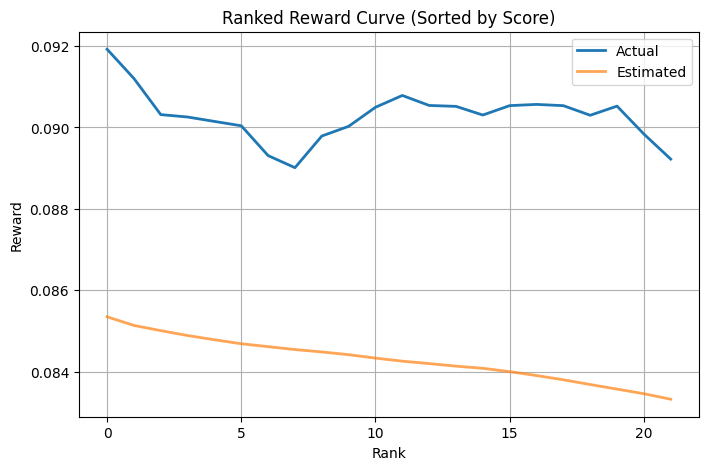

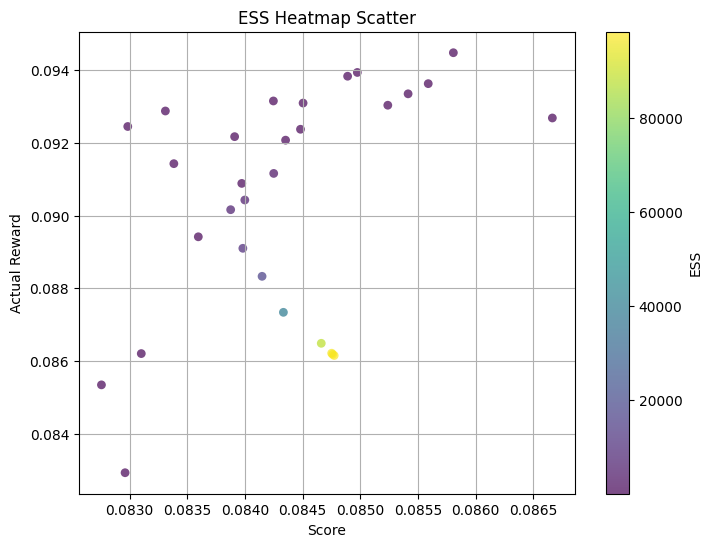

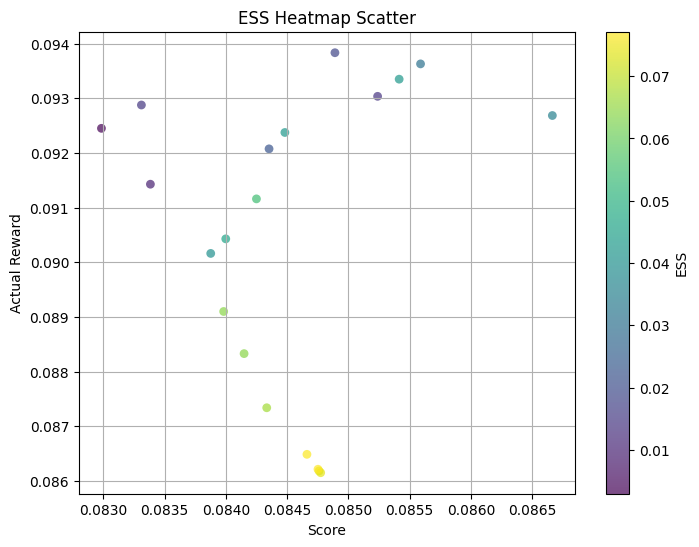

Correlation Metrics: {'pearson_score_actual': np.float64(0.44201960088441666), 'spearman_score_actual': np.float64(0.4923248053392658), 'spearman_est_actual': np.float64(0.19288097886540603)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9957824519931688), 'ndcg_est_actual': np.float64(0.9884394657331836)}
Error Metrics: {'mean_error': np.float64(0.005607838812160635), 'mae': np.float64(0.005615030265214971), 'rmse': np.float64(0.006404737266585986), 'std_error': np.float64(0.003093994717322593), 'max_error': np.float64(0.009336435308416144), 'min_error': np.float64(-0.00010787179581502049)}


In [67]:
compute_statistics_and_plots(study_df6)

In [18]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = emb_dim,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07291694007324749
Optimal greedy CTR: 0.09999912629257961
Second Best greedy CTR: 0.09724450569070416
Optimal Stochastic CTR: 0.09987205538704724
second Best Stochastic CTR: 0.08585387614135936
Our Initial CTR: 0.08588514142470695


In [19]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=80000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 160000 samples: 2.1111598014831543 seconds
[Regression] Baseline regression model fit time: 0.28s
Num samples is 80000
{'gini': np.float64(0.42276891273592854), 'ess': np.float64(39441.331642314784), 'max_wi': np.float64(90.54077420063948), 'min_wi': np.float64(0.01493015702876215)}
Eval time: 28.504249334335327 seconds
Evaluation total results time: 53.48 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:16:55,441] A new study created in memory with name: no-name-ab636026-0b0b-4bd4-8cdf-f6f941f5bdd0


Simulation time for 330000 samples: 4.144139051437378 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09092317]


Best trial: 0. Best value: 0.0864382:   3%|▎         | 1/30 [00:35<17:10, 35.52s/it]

[I 2026-01-04 11:17:30,961] Trial 0 finished with value: 0.08643822128393501 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 1
actual reward: [0.0861938]


Best trial: 0. Best value: 0.0864382:   7%|▋         | 2/30 [00:51<11:09, 23.92s/it]

[I 2026-01-04 11:17:46,766] Trial 1 finished with value: 0.08420166677541298 and parameters: {'lr': 0.0001245321967669912, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9538240007352199}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 2
actual reward: [0.08642238]


Best trial: 0. Best value: 0.0864382:  10%|█         | 3/30 [00:57<07:12, 16.02s/it]

[I 2026-01-04 11:17:53,390] Trial 2 finished with value: 0.08407520669322127 and parameters: {'lr': 0.0007115930780190277, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9137047761179018}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 3
actual reward: [0.07833553]


Best trial: 0. Best value: 0.0864382:  13%|█▎        | 4/30 [01:04<05:24, 12.48s/it]

[I 2026-01-04 11:18:00,437] Trial 3 finished with value: 0.08329781082510815 and parameters: {'lr': 0.09855397288194674, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8878238886122075}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 4
actual reward: [0.08690563]


Best trial: 0. Best value: 0.0864382:  17%|█▋        | 5/30 [01:22<05:54, 14.20s/it]

[I 2026-01-04 11:18:17,684] Trial 4 finished with value: 0.08396939344298683 and parameters: {'lr': 0.0010927269273486079, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.859218121401063}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 5
actual reward: [0.08536375]


Best trial: 0. Best value: 0.0864382:  20%|██        | 6/30 [01:27<04:29, 11.23s/it]

[I 2026-01-04 11:18:23,163] Trial 5 finished with value: 0.083778115989813 and parameters: {'lr': 0.03622223826514197, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8968357449737602}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 6
actual reward: [0.08592331]


Best trial: 0. Best value: 0.0864382:  23%|██▎       | 7/30 [01:46<05:13, 13.64s/it]

[I 2026-01-04 11:18:41,757] Trial 6 finished with value: 0.08307888264423746 and parameters: {'lr': 0.02511455809300771, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8157608505287239}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 7
actual reward: [0.0888876]


Best trial: 7. Best value: 0.086767:  27%|██▋       | 8/30 [02:03<05:27, 14.87s/it] 

[I 2026-01-04 11:18:59,271] Trial 7 finished with value: 0.08676702463520425 and parameters: {'lr': 0.0066245933868356414, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9724276452082328}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 8
actual reward: [0.08970357]


Best trial: 7. Best value: 0.086767:  30%|███       | 9/30 [02:13<04:40, 13.38s/it]

[I 2026-01-04 11:19:09,363] Trial 8 finished with value: 0.08607138313874613 and parameters: {'lr': 0.009762504526051527, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9943691924277289}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 9
actual reward: [0.08350341]


Best trial: 7. Best value: 0.086767:  33%|███▎      | 10/30 [02:23<04:01, 12.09s/it]

[I 2026-01-04 11:19:18,575] Trial 9 finished with value: 0.08391137001620994 and parameters: {'lr': 0.0706963745125034, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9141751547595773}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 10
actual reward: [0.08674285]


Best trial: 10. Best value: 0.0875318:  37%|███▋      | 11/30 [02:37<04:01, 12.71s/it]

[I 2026-01-04 11:19:32,697] Trial 10 finished with value: 0.08753183477293185 and parameters: {'lr': 0.008479407123161715, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9464779746184603}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 11
actual reward: [0.08601559]


Best trial: 10. Best value: 0.0875318:  40%|████      | 12/30 [02:51<03:55, 13.11s/it]

[I 2026-01-04 11:19:46,713] Trial 11 finished with value: 0.08739908206824377 and parameters: {'lr': 0.007810308258990984, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9513366172402423}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 12
actual reward: [0.08712185]


Best trial: 10. Best value: 0.0875318:  43%|████▎     | 13/30 [03:03<03:39, 12.89s/it]

[I 2026-01-04 11:19:59,090] Trial 12 finished with value: 0.08716412657980692 and parameters: {'lr': 0.009750480410596224, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9418308009236015}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 13
actual reward: [0.08791605]


Best trial: 10. Best value: 0.0875318:  47%|████▋     | 14/30 [03:16<03:23, 12.74s/it]

[I 2026-01-04 11:20:11,488] Trial 13 finished with value: 0.08375345564279536 and parameters: {'lr': 0.0025443449221156916, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9442843829014428}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 14
actual reward: [0.09018785]


Best trial: 10. Best value: 0.0875318:  50%|█████     | 15/30 [03:35<03:43, 14.90s/it]

[I 2026-01-04 11:20:31,389] Trial 14 finished with value: 0.08615112587489857 and parameters: {'lr': 0.015057471491963235, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9425712658429561}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 15
actual reward: [0.08835669]


Best trial: 10. Best value: 0.0875318:  53%|█████▎    | 16/30 [03:46<03:11, 13.67s/it]

[I 2026-01-04 11:20:42,213] Trial 15 finished with value: 0.08423556322670604 and parameters: {'lr': 0.00463309999757775, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8564982801032649}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 16
actual reward: [0.08682972]


Best trial: 10. Best value: 0.0875318:  57%|█████▋    | 17/30 [04:00<02:59, 13.78s/it]

[I 2026-01-04 11:20:56,252] Trial 16 finished with value: 0.08397475892490344 and parameters: {'lr': 0.0007317817978530616, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9236036972497704}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 17
actual reward: [0.08719559]


Best trial: 10. Best value: 0.0875318:  60%|██████    | 18/30 [04:20<03:05, 15.49s/it]

[I 2026-01-04 11:21:15,705] Trial 17 finished with value: 0.08478587031237951 and parameters: {'lr': 0.02974592984773064, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9696430948698274}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 18
actual reward: [0.08658714]


Best trial: 10. Best value: 0.0875318:  63%|██████▎   | 19/30 [04:42<03:12, 17.51s/it]

[I 2026-01-04 11:21:37,935] Trial 18 finished with value: 0.08404532349164041 and parameters: {'lr': 0.00017129041011459077, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9984753160795764}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 19
actual reward: [0.08667634]


Best trial: 10. Best value: 0.0875318:  67%|██████▋   | 20/30 [04:53<02:35, 15.53s/it]

[I 2026-01-04 11:21:48,839] Trial 19 finished with value: 0.08390164683502203 and parameters: {'lr': 0.0013544750845362827, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.870806559357562}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 20
actual reward: [0.08801768]


Best trial: 10. Best value: 0.0875318:  70%|███████   | 21/30 [05:07<02:15, 15.09s/it]

[I 2026-01-04 11:22:02,898] Trial 20 finished with value: 0.08398407022343797 and parameters: {'lr': 0.003959900620837484, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.809301044418425}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 21
actual reward: [0.08781432]


Best trial: 10. Best value: 0.0875318:  73%|███████▎  | 22/30 [05:20<01:54, 14.34s/it]

[I 2026-01-04 11:22:15,481] Trial 21 finished with value: 0.08595675692757097 and parameters: {'lr': 0.012638874959678829, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9281527403361713}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 22
actual reward: [0.0882807]


Best trial: 10. Best value: 0.0875318:  77%|███████▋  | 23/30 [05:32<01:36, 13.82s/it]

[I 2026-01-04 11:22:28,094] Trial 22 finished with value: 0.08748329760219034 and parameters: {'lr': 0.00663704905612651, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.960730313660211}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 23
actual reward: [0.08734102]


Best trial: 10. Best value: 0.0875318:  80%|████████  | 24/30 [05:46<01:23, 13.88s/it]

[I 2026-01-04 11:22:42,109] Trial 23 finished with value: 0.08701346235813892 and parameters: {'lr': 0.005369483957275569, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9636806337612918}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 24
actual reward: [0.08688709]


Best trial: 10. Best value: 0.0875318:  83%|████████▎ | 25/30 [06:04<01:15, 15.01s/it]

[I 2026-01-04 11:22:59,767] Trial 24 finished with value: 0.0847843126439123 and parameters: {'lr': 0.018935250836064645, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9828785602338016}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 25
actual reward: [0.08655467]


Best trial: 10. Best value: 0.0875318:  87%|████████▋ | 26/30 [06:15<00:55, 13.76s/it]

[I 2026-01-04 11:23:10,593] Trial 25 finished with value: 0.0836800807759617 and parameters: {'lr': 0.0018439532263194768, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9537492574885521}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 26
actual reward: [0.08555988]


Best trial: 10. Best value: 0.0875318:  90%|█████████ | 27/30 [06:31<00:43, 14.46s/it]

[I 2026-01-04 11:23:26,681] Trial 26 finished with value: 0.08270866720600534 and parameters: {'lr': 0.04646802870142878, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9321392213983768}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 27
actual reward: [0.09037125]


Best trial: 10. Best value: 0.0875318:  93%|█████████▎| 28/30 [06:48<00:30, 15.35s/it]

[I 2026-01-04 11:23:44,131] Trial 27 finished with value: 0.08677394169890322 and parameters: {'lr': 0.007506298370556574, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9556517901213979}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 28
actual reward: [0.08687623]


Best trial: 10. Best value: 0.0875318:  97%|█████████▋| 29/30 [07:23<00:21, 21.23s/it]

[I 2026-01-04 11:24:19,069] Trial 28 finished with value: 0.08408053871582433 and parameters: {'lr': 0.0003941895288510788, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9174178333323093}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 29
actual reward: [0.09158083]


Best trial: 10. Best value: 0.0875318: 100%|██████████| 30/30 [07:58<00:00, 15.95s/it]


[I 2026-01-04 11:24:54,033] Trial 29 finished with value: 0.08597516834440079 and parameters: {'lr': 0.0028511697937857175, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9816982765390773}. Best is trial 10 with value: 0.08753183477293185.
Num samples is 80000
{'gini': np.float64(0.9975377886511231), 'ess': np.float64(31.620929843867806), 'max_wi': np.float64(9857.071177825266), 'min_wi': np.float64(2.3354617020392347e-13)}
Eval time: 27.67410945892334 seconds
Evaluation total results time: 52.54 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08588514,0.08595000,0.08737445,0.08737445,0.08595923,0.08595923,0.74312065,0.00000000,0.81966391,0.00000000
250000,0.08847580,0.05351079,0.08646778,0.08646778,0.05453972,0.05345479,0.92992574,0.50149700,1.16463175,0.58406784


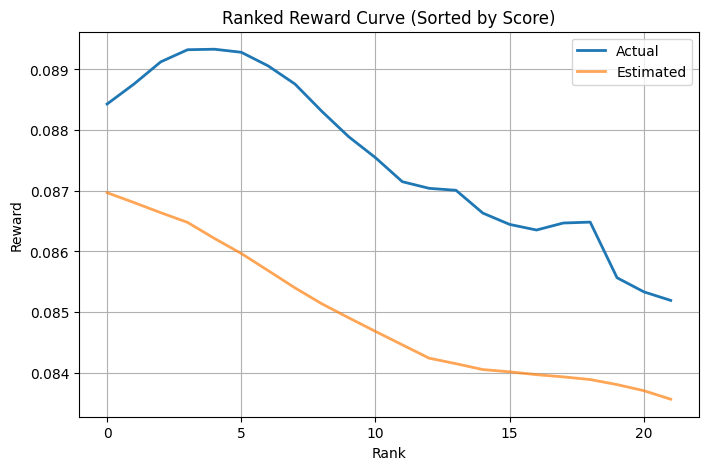

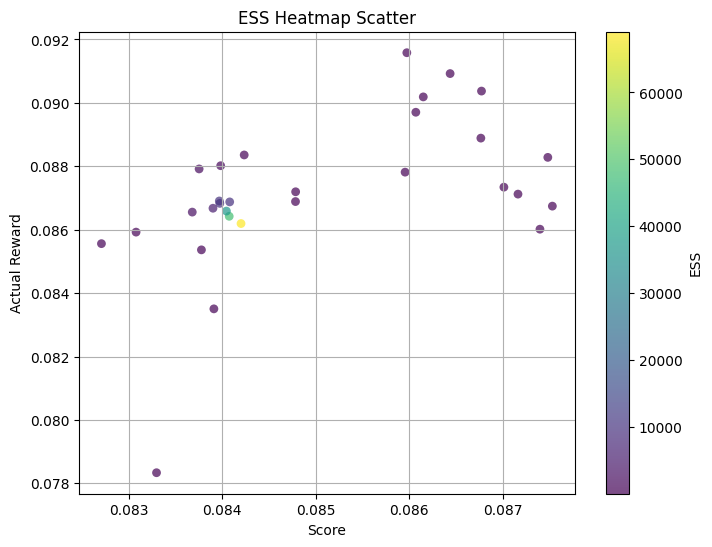

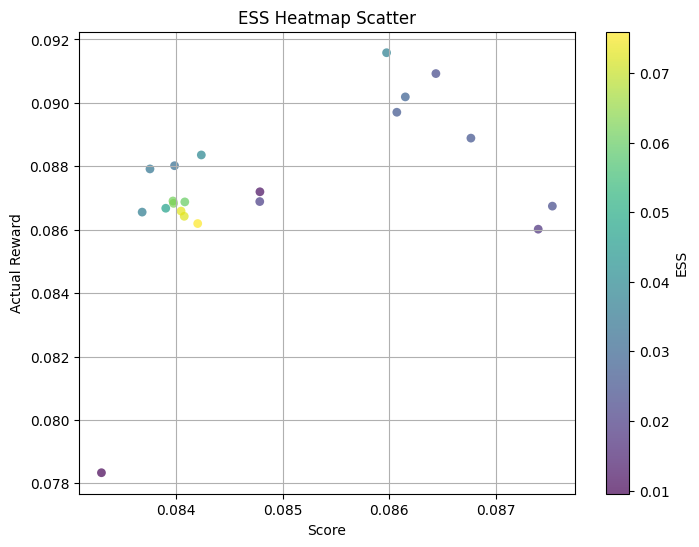

Correlation Metrics: {'pearson_score_actual': np.float64(0.5042808282401985), 'spearman_score_actual': np.float64(0.578642936596218), 'spearman_est_actual': np.float64(0.5279199110122358)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.992157534607615), 'ndcg_est_actual': np.float64(0.9920925401712317)}
Error Metrics: {'mean_error': np.float64(0.0017465907146017627), 'mae': np.float64(0.0023037332152972636), 'rmse': np.float64(0.0026766616998448976), 'std_error': np.float64(0.0020282846770321664), 'max_error': np.float64(0.005307093857296663), 'min_error': np.float64(-0.00503208765712361)}


In [68]:
compute_statistics_and_plots(study_df7)

In [69]:
# dataset_params = dict(
#                     n_actions= 2000,
#                     n_users = 2000,
#                     emb_dim = 12,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07308232681176861
Optimal greedy CTR: 0.0999990548267266
Second Best greedy CTR: 0.09762368115504418
Optimal Stochastic CTR: 0.09985850946040746
second Best Stochastic CTR: 0.08550862146517685
Our Initial CTR: 0.08553621872917394


In [22]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=80000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 160000 samples: 2.073413133621216 seconds
[Regression] Baseline regression model fit time: 0.38s
Num samples is 80000
{'gini': np.float64(0.41413190202081634), 'ess': np.float64(42195.313239496245), 'max_wi': np.float64(28.136123300175946), 'min_wi': np.float64(0.011826056620047602)}
Eval time: 28.130189657211304 seconds
Evaluation total results time: 53.14 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:27:02,139] A new study created in memory with name: no-name-6f737fa3-5cde-4c0b-8c85-96ae0cb86fd4


Simulation time for 330000 samples: 4.153632640838623 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09179286]


Best trial: 0. Best value: 0.0870354:   3%|▎         | 1/30 [00:35<17:03, 35.28s/it]

[I 2026-01-04 11:27:37,417] Trial 0 finished with value: 0.08703544789055408 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 1
actual reward: [0.08756385]


Best trial: 0. Best value: 0.0870354:   7%|▋         | 2/30 [00:51<11:08, 23.88s/it]

[I 2026-01-04 11:27:53,321] Trial 1 finished with value: 0.08271047766686336 and parameters: {'lr': 0.0346676502054522, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9101973027671377}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 2
actual reward: [0.07916537]


Best trial: 0. Best value: 0.0870354:  10%|█         | 3/30 [01:03<08:24, 18.67s/it]

[I 2026-01-04 11:28:05,799] Trial 2 finished with value: 0.08364049958614639 and parameters: {'lr': 0.09850067087453228, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9444496771662938}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 3
actual reward: [0.08582369]


Best trial: 3. Best value: 0.0875286:  13%|█▎        | 4/30 [01:18<07:23, 17.05s/it]

[I 2026-01-04 11:28:20,362] Trial 3 finished with value: 0.08752856067265885 and parameters: {'lr': 0.00775746569391874, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8866377342257958}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 4
actual reward: [0.08138002]


Best trial: 3. Best value: 0.0875286:  17%|█▋        | 5/30 [01:31<06:31, 15.64s/it]

[I 2026-01-04 11:28:33,510] Trial 4 finished with value: 0.08292153444375283 and parameters: {'lr': 0.09474240266716719, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8281528294763094}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 5
actual reward: [0.08535178]


Best trial: 3. Best value: 0.0875286:  20%|██        | 6/30 [01:42<05:36, 14.00s/it]

[I 2026-01-04 11:28:44,328] Trial 5 finished with value: 0.0834528852674299 and parameters: {'lr': 0.0003617545069852752, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9092436521842525}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 6
actual reward: [0.08658292]


Best trial: 3. Best value: 0.0875286:  23%|██▎       | 7/30 [02:06<06:42, 17.48s/it]

[I 2026-01-04 11:29:08,969] Trial 6 finished with value: 0.08465385512269047 and parameters: {'lr': 0.0008886283421656754, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.858447450558401}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 7
actual reward: [0.09098746]


Best trial: 7. Best value: 0.0877292:  27%|██▋       | 8/30 [02:31<07:16, 19.86s/it]

[I 2026-01-04 11:29:33,932] Trial 7 finished with value: 0.08772917781899835 and parameters: {'lr': 0.004157714629473571, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9246256391516755}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 8
actual reward: [0.08268927]


Best trial: 7. Best value: 0.0877292:  30%|███       | 9/30 [02:46<06:22, 18.24s/it]

[I 2026-01-04 11:29:48,589] Trial 8 finished with value: 0.08213180311660873 and parameters: {'lr': 0.058272246190307984, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8754312533582023}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 9
actual reward: [0.08498781]


Best trial: 7. Best value: 0.0877292:  33%|███▎      | 10/30 [03:06<06:13, 18.70s/it]

[I 2026-01-04 11:30:08,315] Trial 9 finished with value: 0.08338639096841326 and parameters: {'lr': 0.00042806283937973336, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.882458919159498}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 10
actual reward: [0.085554]


Best trial: 7. Best value: 0.0877292:  37%|███▋      | 11/30 [03:13<04:50, 15.29s/it]

[I 2026-01-04 11:30:15,873] Trial 10 finished with value: 0.08347805503159589 and parameters: {'lr': 0.00011654182675399952, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9999478867375717}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 11
actual reward: [0.08986621]


Best trial: 7. Best value: 0.0877292:  40%|████      | 12/30 [03:33<04:58, 16.57s/it]

[I 2026-01-04 11:30:35,364] Trial 11 finished with value: 0.08646380460721792 and parameters: {'lr': 0.009216768020276366, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9378477943746532}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 12
actual reward: [0.08976352]


Best trial: 7. Best value: 0.0877292:  43%|████▎     | 13/30 [03:51<04:52, 17.22s/it]

[I 2026-01-04 11:30:54,091] Trial 12 finished with value: 0.0862555698864879 and parameters: {'lr': 0.009061618808430393, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8375030816847723}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 13
actual reward: [0.09161411]


Best trial: 7. Best value: 0.0877292:  47%|████▋     | 14/30 [04:19<05:23, 20.24s/it]

[I 2026-01-04 11:31:21,298] Trial 13 finished with value: 0.08601971831353705 and parameters: {'lr': 0.007680210300238064, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9442940311644658}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 14
actual reward: [0.08546845]


Best trial: 7. Best value: 0.0877292:  50%|█████     | 15/30 [04:26<04:07, 16.49s/it]

[I 2026-01-04 11:31:29,101] Trial 14 finished with value: 0.08283061618231233 and parameters: {'lr': 0.0031801986942949657, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9160146091581055}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 15
actual reward: [0.08340369]


Best trial: 7. Best value: 0.0877292:  53%|█████▎    | 16/30 [04:32<03:03, 13.08s/it]

[I 2026-01-04 11:31:34,279] Trial 15 finished with value: 0.08274985608447474 and parameters: {'lr': 0.02462516467634953, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.801998725509526}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 16
actual reward: [0.08689557]


Best trial: 7. Best value: 0.0877292:  57%|█████▋    | 17/30 [04:44<02:49, 13.01s/it]

[I 2026-01-04 11:31:47,122] Trial 16 finished with value: 0.08337131242122349 and parameters: {'lr': 0.0025293308136469356, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8846502794449079}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 17
actual reward: [0.08810773]


Best trial: 7. Best value: 0.0877292:  60%|██████    | 18/30 [05:22<04:03, 20.29s/it]

[I 2026-01-04 11:32:24,368] Trial 17 finished with value: 0.08350341611637274 and parameters: {'lr': 0.01572380935862991, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9653983732956495}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 18
actual reward: [0.08953287]


Best trial: 18. Best value: 0.0878705:  63%|██████▎   | 19/30 [05:37<03:25, 18.64s/it]

[I 2026-01-04 11:32:39,158] Trial 18 finished with value: 0.08787053696535715 and parameters: {'lr': 0.004116500022723437, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9265897910295168}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 19
actual reward: [0.08624495]


Best trial: 18. Best value: 0.0878705:  67%|██████▋   | 20/30 [05:49<02:47, 16.76s/it]

[I 2026-01-04 11:32:51,538] Trial 19 finished with value: 0.08444819363457529 and parameters: {'lr': 0.0011691159468179462, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9285970012078089}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 20
actual reward: [0.09034999]


Best trial: 18. Best value: 0.0878705:  70%|███████   | 21/30 [06:04<02:25, 16.19s/it]

[I 2026-01-04 11:33:06,395] Trial 20 finished with value: 0.08779286325886741 and parameters: {'lr': 0.003920600468712365, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9724234275169326}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 21
actual reward: [0.08949481]


Best trial: 21. Best value: 0.0879991:  73%|███████▎  | 22/30 [06:19<02:06, 15.86s/it]

[I 2026-01-04 11:33:21,481] Trial 21 finished with value: 0.08799905384051641 and parameters: {'lr': 0.004284971813588696, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9551386353106072}. Best is trial 21 with value: 0.08799905384051641.

[Regression] Optuna Trial 22
actual reward: [0.08751266]


Best trial: 21. Best value: 0.0879991:  77%|███████▋  | 23/30 [06:34<01:48, 15.55s/it]

[I 2026-01-04 11:33:36,326] Trial 22 finished with value: 0.08602909947462009 and parameters: {'lr': 0.001565256574064884, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9692473856028821}. Best is trial 21 with value: 0.08799905384051641.

[Regression] Optuna Trial 23
actual reward: [0.08846981]


Best trial: 23. Best value: 0.0880397:  80%|████████  | 24/30 [06:46<01:27, 14.57s/it]

[I 2026-01-04 11:33:48,616] Trial 23 finished with value: 0.08803972472387976 and parameters: {'lr': 0.005662556242201493, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9590427214956639}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 24
actual reward: [0.08974854]


Best trial: 23. Best value: 0.0880397:  83%|████████▎ | 25/30 [06:56<01:05, 13.19s/it]

[I 2026-01-04 11:33:58,588] Trial 24 finished with value: 0.08643477560452262 and parameters: {'lr': 0.015448061734148448, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9975221798245705}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 25
actual reward: [0.08932965]


Best trial: 23. Best value: 0.0880397:  87%|████████▋ | 26/30 [07:08<00:51, 13.00s/it]

[I 2026-01-04 11:34:11,131] Trial 25 finished with value: 0.08757317781276791 and parameters: {'lr': 0.005392314900071211, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9583655416755062}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 26
actual reward: [0.08631286]


Best trial: 23. Best value: 0.0880397:  90%|█████████ | 27/30 [07:19<00:36, 12.14s/it]

[I 2026-01-04 11:34:21,262] Trial 26 finished with value: 0.08501497095115403 and parameters: {'lr': 0.0016753818803133345, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9521016402931883}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 27
actual reward: [0.08566379]


Best trial: 23. Best value: 0.0880397:  93%|█████████▎| 28/30 [07:36<00:27, 13.71s/it]

[I 2026-01-04 11:34:38,638] Trial 27 finished with value: 0.08684003617361867 and parameters: {'lr': 0.014476188937202936, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9316637305439268}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 28
actual reward: [0.08499834]


Best trial: 23. Best value: 0.0880397:  97%|█████████▋| 29/30 [07:48<00:13, 13.25s/it]

[I 2026-01-04 11:34:50,819] Trial 28 finished with value: 0.08344832113319814 and parameters: {'lr': 0.0006323197162572856, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9843574214267629}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 29
actual reward: [0.0870757]


Best trial: 23. Best value: 0.0880397: 100%|██████████| 30/30 [07:59<00:00, 15.99s/it]


[I 2026-01-04 11:35:01,690] Trial 29 finished with value: 0.08597750070098872 and parameters: {'lr': 0.0017975776833381273, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9777294714481386}. Best is trial 23 with value: 0.08803972472387976.
Num samples is 80000
{'gini': np.float64(0.9954166756460068), 'ess': np.float64(10.566569085155688), 'max_wi': np.float64(33351.89050441621), 'min_wi': np.float64(2.943028261259537e-09)}
Eval time: 28.078977346420288 seconds
Evaluation total results time: 52.91 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08553622,0.08546250,0.08681966,0.08681966,0.08546309,0.08546309,0.73278217,0.00000000,0.96825810,0.00000000
250000,0.08789727,0.10570449,0.08587999,0.08587999,0.10720464,0.10622043,0.91841006,0.37239948,1.14000010,0.32051809


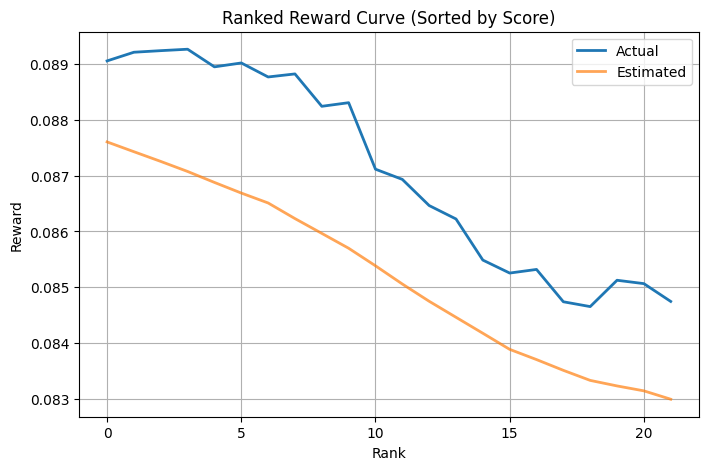

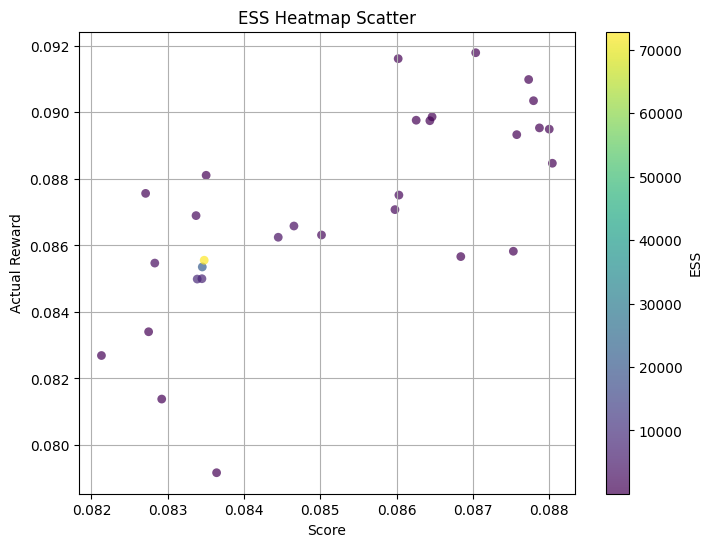

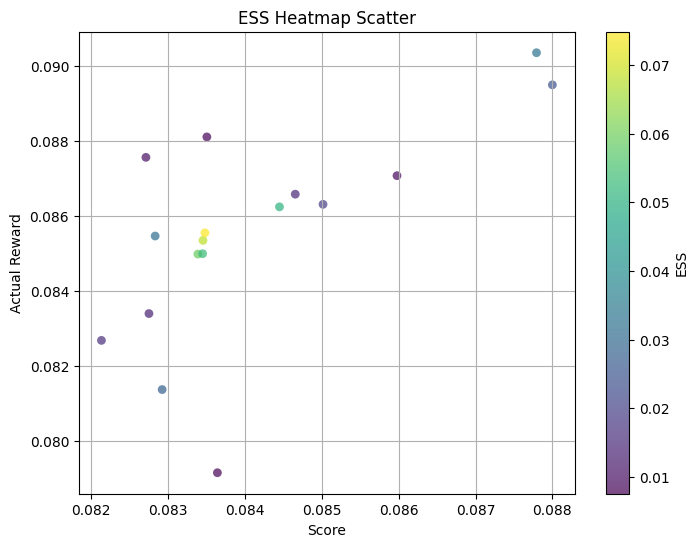

Correlation Metrics: {'pearson_score_actual': np.float64(0.703968461782406), 'spearman_score_actual': np.float64(0.7001112347052281), 'spearman_est_actual': np.float64(0.6912124582869855)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9946379247695246), 'ndcg_est_actual': np.float64(0.9946969734588152)}
Error Metrics: {'mean_error': np.float64(0.001465955798851192), 'mae': np.float64(0.0021004244661582414), 'rmse': np.float64(0.002544709261644625), 'std_error': np.float64(0.0020800285628121786), 'max_error': np.float64(0.005351235560154363), 'min_error': np.float64(-0.004540719096727541)}


In [70]:
compute_statistics_and_plots(study_df8)

In [24]:
# dataset_params = dict(
#                     n_actions= 500,
#                     n_users = 500,
#                     emb_dim = 16,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.07308925129657047
Optimal greedy CTR: 0.0999990853390176
Second Best greedy CTR: 0.09942382949421147
Optimal Stochastic CTR: 0.0998654433282965
second Best Stochastic CTR: 0.08593335882324721
Our Initial CTR: 0.08596028929347854


In [25]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=50000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 100000 samples: 1.3119654655456543 seconds
[Regression] Baseline regression model fit time: 0.25s
Num samples is 50000
{'gini': np.float64(0.4124079474973358), 'ess': np.float64(26327.708667387877), 'max_wi': np.float64(41.113816910618816), 'min_wi': np.float64(0.012848733171872868)}
Eval time: 18.920714378356934 seconds
Evaluation total results time: 35.12 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:36:45,355] A new study created in memory with name: no-name-32ecd6b6-d25d-4f66-bd4a-6098d19429a7


Simulation time for 300000 samples: 3.807964563369751 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09352565]


Best trial: 0. Best value: 0.0853091:   3%|▎         | 1/30 [00:34<16:48, 34.77s/it]

[I 2026-01-04 11:37:20,127] Trial 0 finished with value: 0.0853091228741955 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.0853091228741955.

[Regression] Optuna Trial 1
actual reward: [0.09291042]


Best trial: 1. Best value: 0.0857178:   7%|▋         | 2/30 [00:48<10:29, 22.48s/it]

[I 2026-01-04 11:37:33,996] Trial 1 finished with value: 0.08571778234922227 and parameters: {'lr': 0.008030090778924517, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9675257523608418}. Best is trial 1 with value: 0.08571778234922227.

[Regression] Optuna Trial 2
actual reward: [0.08750002]


Best trial: 1. Best value: 0.0857178:  10%|█         | 3/30 [00:59<07:46, 17.28s/it]

[I 2026-01-04 11:37:45,091] Trial 2 finished with value: 0.08407232389498699 and parameters: {'lr': 0.001208569554914711, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8561958442100326}. Best is trial 1 with value: 0.08571778234922227.

[Regression] Optuna Trial 3
actual reward: [0.08999004]


Best trial: 3. Best value: 0.08662:  13%|█▎        | 4/30 [01:10<06:25, 14.82s/it]  

[I 2026-01-04 11:37:56,149] Trial 3 finished with value: 0.08661998356458277 and parameters: {'lr': 0.030698619156523825, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8626725524234616}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 4
actual reward: [0.08818428]


Best trial: 3. Best value: 0.08662:  17%|█▋        | 5/30 [01:18<05:10, 12.41s/it]

[I 2026-01-04 11:38:04,285] Trial 4 finished with value: 0.08472188412713019 and parameters: {'lr': 0.0020355873289586235, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9702251472835816}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 5
actual reward: [0.0799287]


Best trial: 3. Best value: 0.08662:  20%|██        | 6/30 [01:43<06:33, 16.41s/it]

[I 2026-01-04 11:38:28,462] Trial 5 finished with value: 0.08598004626763127 and parameters: {'lr': 0.07367951140276428, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9757983785234667}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 6
actual reward: [0.08633175]


Best trial: 3. Best value: 0.08662:  23%|██▎       | 7/30 [02:01<06:31, 17.01s/it]

[I 2026-01-04 11:38:46,707] Trial 6 finished with value: 0.08289172374768346 and parameters: {'lr': 0.00011620972232018312, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8920632770197184}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 7
actual reward: [0.08096384]


Best trial: 3. Best value: 0.08662:  27%|██▋       | 8/30 [02:32<07:50, 21.39s/it]

[I 2026-01-04 11:39:17,482] Trial 7 finished with value: 0.08576207994735538 and parameters: {'lr': 0.05454682265768181, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8418125284033187}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 8
actual reward: [0.08646173]


Best trial: 3. Best value: 0.08662:  30%|███       | 9/30 [02:49<07:03, 20.15s/it]

[I 2026-01-04 11:39:34,914] Trial 8 finished with value: 0.08299132636102216 and parameters: {'lr': 0.0001454147337353797, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9546128375896935}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 9
actual reward: [0.09057251]


Best trial: 3. Best value: 0.08662:  33%|███▎      | 10/30 [03:05<06:14, 18.74s/it]

[I 2026-01-04 11:39:50,498] Trial 9 finished with value: 0.08536334546371557 and parameters: {'lr': 0.003393958771018335, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8741873960304742}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 10
actual reward: [0.08778861]


Best trial: 3. Best value: 0.08662:  37%|███▋      | 11/30 [03:08<04:29, 14.18s/it]

[I 2026-01-04 11:39:54,320] Trial 10 finished with value: 0.085854135914001 and parameters: {'lr': 0.019611276825628726, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8044045690354128}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 11
actual reward: [0.07749721]


Best trial: 3. Best value: 0.08662:  40%|████      | 12/30 [03:35<05:22, 17.94s/it]

[I 2026-01-04 11:40:20,858] Trial 11 finished with value: 0.0858518538315592 and parameters: {'lr': 0.09828884679150705, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.920846772373821}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 12
actual reward: [0.08909834]


Best trial: 3. Best value: 0.08662:  43%|████▎     | 13/30 [03:49<04:46, 16.83s/it]

[I 2026-01-04 11:40:35,126] Trial 12 finished with value: 0.0854844688055345 and parameters: {'lr': 0.03101083230939522, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9279700186849246}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 13
actual reward: [0.08979141]


Best trial: 3. Best value: 0.08662:  47%|████▋     | 14/30 [03:54<03:29, 13.10s/it]

[I 2026-01-04 11:40:39,602] Trial 13 finished with value: 0.08528549412809876 and parameters: {'lr': 0.013813728631218873, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8326644964817571}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 14
actual reward: [0.08107857]


Best trial: 3. Best value: 0.08662:  50%|█████     | 15/30 [04:10<03:32, 14.19s/it]

[I 2026-01-04 11:40:56,326] Trial 14 finished with value: 0.08526274405957406 and parameters: {'lr': 0.08938423078933568, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.922736527215514}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 15
actual reward: [0.09081757]


Best trial: 3. Best value: 0.08662:  53%|█████▎    | 16/30 [04:17<02:46, 11.90s/it]

[I 2026-01-04 11:41:02,895] Trial 15 finished with value: 0.08567994201988018 and parameters: {'lr': 0.007759421380781638, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8904148578089418}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 16
actual reward: [0.08451811]


Best trial: 3. Best value: 0.08662:  57%|█████▋    | 17/30 [04:44<03:34, 16.50s/it]

[I 2026-01-04 11:41:30,108] Trial 16 finished with value: 0.08567555192465287 and parameters: {'lr': 0.031840435279432845, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9938910478144445}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 17
actual reward: [0.08732078]


Best trial: 3. Best value: 0.08662:  60%|██████    | 18/30 [04:58<03:09, 15.75s/it]

[I 2026-01-04 11:41:44,112] Trial 17 finished with value: 0.0838309441193317 and parameters: {'lr': 0.0004942717927577964, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9415485417996029}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 18
actual reward: [0.09018045]


Best trial: 3. Best value: 0.08662:  63%|██████▎   | 19/30 [05:05<02:22, 13.00s/it]

[I 2026-01-04 11:41:50,702] Trial 18 finished with value: 0.08557256605612684 and parameters: {'lr': 0.0072686052494137935, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8048584877194538}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 19
actual reward: [0.08792942]


Best trial: 3. Best value: 0.08662:  67%|██████▋   | 20/30 [05:24<02:28, 14.86s/it]

[I 2026-01-04 11:42:09,881] Trial 19 finished with value: 0.08536826025940183 and parameters: {'lr': 0.03965163524624606, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8654329753600896}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 20
actual reward: [0.09179934]


Best trial: 3. Best value: 0.08662:  70%|███████   | 21/30 [05:39<02:12, 14.76s/it]

[I 2026-01-04 11:42:24,416] Trial 20 finished with value: 0.08576938198176594 and parameters: {'lr': 0.017425974914894955, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9067903936495811}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 21
actual reward: [0.08751962]


Best trial: 3. Best value: 0.08662:  73%|███████▎  | 22/30 [05:42<01:31, 11.46s/it]

[I 2026-01-04 11:42:28,171] Trial 21 finished with value: 0.08547616152044027 and parameters: {'lr': 0.022286289592588174, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8018545448152136}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 22
actual reward: [0.08318938]


Best trial: 3. Best value: 0.08662:  77%|███████▋  | 23/30 [05:48<01:07,  9.65s/it]

[I 2026-01-04 11:42:33,606] Trial 22 finished with value: 0.08506670626088014 and parameters: {'lr': 0.0620908751559975, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8189585105763432}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 23
actual reward: [0.09032627]


Best trial: 3. Best value: 0.08662:  80%|████████  | 24/30 [05:56<00:56,  9.36s/it]

[I 2026-01-04 11:42:42,289] Trial 23 finished with value: 0.08616408539777728 and parameters: {'lr': 0.015158046645940193, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8478042732378933}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 24
actual reward: [0.09241816]


Best trial: 3. Best value: 0.08662:  83%|████████▎ | 25/30 [06:05<00:45,  9.18s/it]

[I 2026-01-04 11:42:51,055] Trial 24 finished with value: 0.08596735583886567 and parameters: {'lr': 0.010645952291062752, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8482275863572428}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 25
actual reward: [0.09030223]


Best trial: 3. Best value: 0.08662:  87%|████████▋ | 26/30 [06:12<00:34,  8.53s/it]

[I 2026-01-04 11:42:58,055] Trial 25 finished with value: 0.08545493087584399 and parameters: {'lr': 0.005097641800283234, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8771515851754794}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 26
actual reward: [0.08657912]


Best trial: 3. Best value: 0.08662:  90%|█████████ | 27/30 [06:22<00:26,  8.86s/it]

[I 2026-01-04 11:43:07,692] Trial 26 finished with value: 0.08640859142685307 and parameters: {'lr': 0.04979273515824271, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8233661115715334}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 27
actual reward: [0.08999032]


Best trial: 3. Best value: 0.08662:  93%|█████████▎| 28/30 [06:32<00:18,  9.18s/it]

[I 2026-01-04 11:43:17,604] Trial 27 finished with value: 0.08611818377266463 and parameters: {'lr': 0.04512639757956968, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8264361541184909}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 28
actual reward: [0.08813243]


Best trial: 3. Best value: 0.08662:  97%|█████████▋| 29/30 [06:43<00:09,  9.78s/it]

[I 2026-01-04 11:43:28,782] Trial 28 finished with value: 0.08625629074254319 and parameters: {'lr': 0.03158753423920045, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8400091945951765}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 29
actual reward: [0.09069578]


Best trial: 3. Best value: 0.08662: 100%|██████████| 30/30 [06:54<00:00, 13.82s/it]


[I 2026-01-04 11:43:39,830] Trial 29 finished with value: 0.0862761698541707 and parameters: {'lr': 0.02396887779664143, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8180505061353333}. Best is trial 3 with value: 0.08661998356458277.
Num samples is 50000
{'gini': np.float64(0.9977814608605318), 'ess': np.float64(85.96808714609267), 'max_wi': np.float64(1921.1006149850002), 'min_wi': np.float64(9.404824072516591e-24)}
Eval time: 17.671361684799194 seconds
Evaluation total results time: 34.23 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08596029,0.08618000,0.08710767,0.08710767,0.08613821,0.08613821,0.75394551,0.00000000,0.77463545,0.00000000
250000,0.09091867,0.05350842,0.08645057,0.08645057,0.04865297,0.05355782,0.94760972,0.55941053,1.17362708,0.76737838


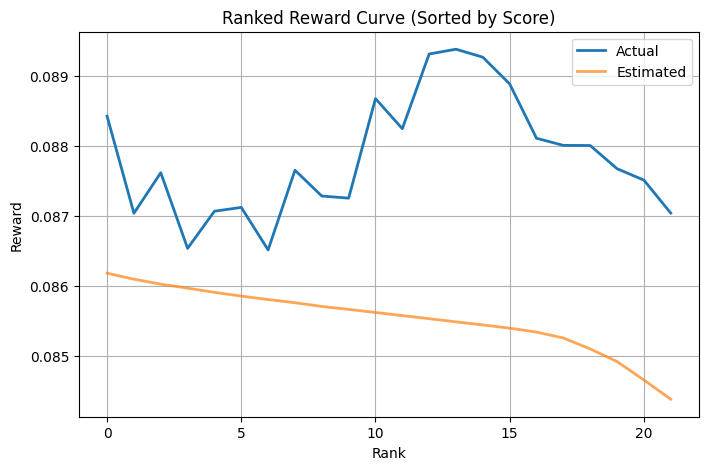

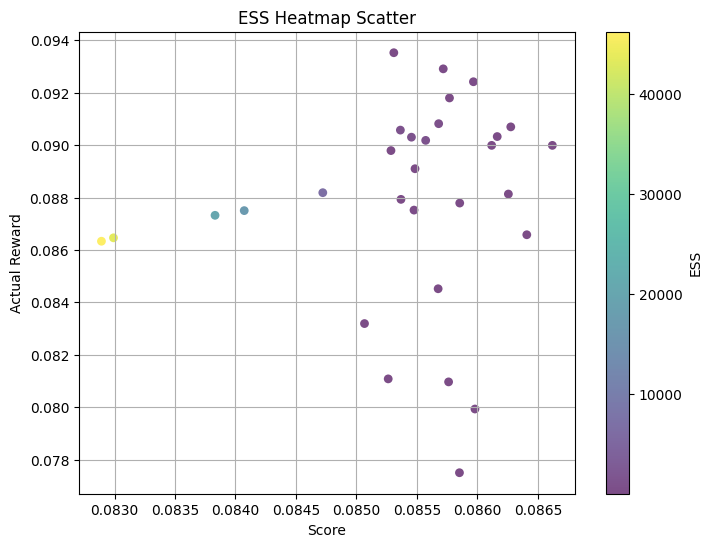

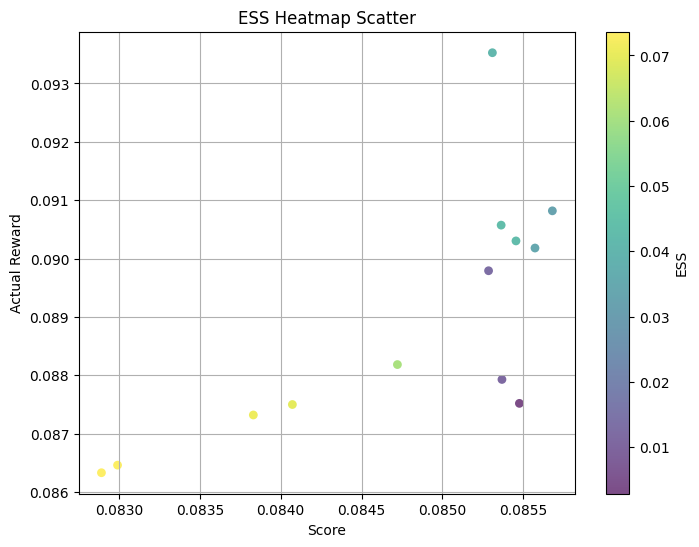

Correlation Metrics: {'pearson_score_actual': np.float64(0.11363860042237824), 'spearman_score_actual': np.float64(0.22180200222469412), 'spearman_est_actual': np.float64(0.4273637374860957)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9880337227118016), 'ndcg_est_actual': np.float64(0.9901907915560961)}
Error Metrics: {'mean_error': np.float64(0.0019224200335612887), 'mae': np.float64(0.00371770261865731), 'rmse': np.float64(0.004227800868536615), 'std_error': np.float64(0.0037654483662056997), 'max_error': np.float64(0.007824652707246874), 'min_error': np.float64(-0.008419363373906585)}


In [72]:
compute_statistics_and_plots(study_df9)

In [27]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [28]:
all_dfs.head(5)

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values
0,0.08778785,0.09011210,0.00014227,0.08806669,413.95921676,"{'dr_naive_mean': 0.08806669102680653, 'dr_nai...","[0.08806669102680653, 0.08806266604342869, 0.0..."
1,0.08625738,0.08681637,0.00014114,0.08653400,317.42173029,"{'dr_naive_mean': 0.08653400137662663, 'dr_nai...","[0.08653400137662663, 0.08652410180235526, 0.0..."
2,0.08461695,0.07246351,0.00004189,0.08469907,354.36741834,"{'dr_naive_mean': 0.08469906706969256, 'dr_nai...","[0.08469906706969256, 0.08468245075554404, 0.0..."
3,0.08428654,0.08029869,0.00006783,0.08441948,669.96306994,"{'dr_naive_mean': 0.08441948274171246, 'dr_nai...","[0.08441948274171246, 0.08441964992054762, 0.0..."
4,0.08353456,0.08030789,0.00022391,0.08397341,"5,652.11056819","{'dr_naive_mean': 0.08397341022882376, 'dr_nai...","[0.08397341022882376, 0.0839641426719494, 0.07..."


In [29]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [30]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [31]:
all_dfs = pd.read_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'regression_model_opl_study_results_all_seeds_30.csv'

In [ ]:
compute_statistics_and_plots(all_dfs)